# Exploratory Data Analysis - Sequences of Credit Card Transactions
With the datasets prepared for analysis, we can investigate if we can uncover relevant global and/or individual purchasing patterns in the clients. Specifically, we will approach this in a way similar to the researchers that wrote the [Sequences of purchases in credit card data reveal
life styles in urban populations](https://www.nature.com/articles/s41467-018-05690-8) paper.

The premise is that we can approach the modeling of spending behavior and lifestyle habits of credit card users by looking at the sequences of events rather than raw transaction values.

This effectively allows for more relevant and less biased representations of customer behavior, as we lessen the effect of very common transactions or people that spend more versus people that spend less.

In [2]:
# installing dependencies:
!pip install -r ../configs/dependencies/modeling_requirements.txt --upgrade >> ../configs/dependencies/package_installation.txt

In [1]:
# loading magic commands
%load_ext lab_black
%load_ext autoreload
%autoreload 2

In [3]:
###### Loading the necessary libraries #########

# data wrangling
import pandas as pd
import numpy as np

# statistical libraries:
from scipy import stats
from sklearn.linear_model import LinearRegression

# plotting and visualization:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML, Image

# other libraries:
import warnings

# setting global parameters for visualizations:
warnings.filterwarnings("ignore")
pd.set_option("display.precision", 4)
pd.set_option("display.float_format", lambda x: "%.2f" % x)

# 0. Helper Functions

In [4]:
def set_plot_settings():
    """Helper function to set standard plot settings for the jupyter notebook
    Note: these are hard-coded for my specific tastes
    """
    %matplotlib inline
    %pylab inline

    plt.rcParams["figure.figsize"] = [10, 6]
    plt.rcParams["figure.dpi"] = 120
    display(HTML("<style>.container { width:100% !important; }</style>"))
    pd.set_option("display.expand_frame_repr", False)
    sns.set_style("white")


def rotate_xticks(ax, rotation):
    """Helper function to rotate x-axis labels of a matplotlib-based plot

    Args:
        ax (axes.AxesSubplot): matplotlib subplot axis object that handles the figure
        rotation (int): degrees for which to rotate the axis x-ticks

    Returns:
        None

    """
    for item in ax.get_xticklabels():
        item.set_rotation(rotation)


def plot_log_model(df, model, plot_title):
    """Helper function to build the log-log plots for linear model fits

    Args:
        df (pandas.DataFrame): pandas DataFrame containing the data for the experiment
        model (sklearn.linear_model.LinearRegression): the fitted linear model for comparison
        plot_title (str): A title for the plot

    Returns:
        None (prints to standard out)

    """

    # performing the predictions:
    y_pred = model.predict(df["x_log"].values.reshape(-1, 1))

    fig, axs = plt.subplots(figsize=(8, 6))

    # plotting a scatter plot of the data:
    axs.scatter(df.x, df.y, alpha=0.8, linewidths=0.8, marker="o")
    axs.scatter(df.x, np.exp(y_pred), alpha=0.6, linewidths=0.8, marker="*")

    # setting the scales:
    axs.set_yscale("log")
    axs.set_xscale("log")

    # setting plot metadata
    axs.set_title(plot_title)
    axs.legend(["Samples of the data", "Samples of the fitted linear model"])

    return True


def plot_zipf_sample(x, sample, zipf, plot_title):
    """Helper function to build the log-log plots for zipf distribution fits

    Args:
        x (numpy.ndarray): the array containing the ranks from the samples
        sample (numpy.ndarray): the samples for the real data
        zipf (numpy.ndarrray): the samples form the fitted zipf distribution
        plot_title (str): A title for the plot

    Returns:
        None (prints to standard out)

    """

    fig, axs = plt.subplots(figsize=(8, 6))

    # plotting a scatter plot of the data:
    axs.scatter(x, sample, alpha=0.8, linewidths=0.8, marker="o")
    axs.scatter(x, zipf, alpha=0.6, linewidths=0.8, marker="*")

    # setting the scales:
    axs.set_yscale("log")
    axs.set_xscale("log")

    # setting plot metadata
    axs.set_title(plot_title)
    axs.legend(["Samples of the data", "Samples of the fitted Zipf distribution"])

    return True

In [5]:
# setting the global variables for plotting:
set_plot_settings()

Populating the interactive namespace from numpy and matplotlib


# 1. Loading and Inspecting the Data

In [7]:
# loading the raw dataset:
PROCESSED_DATA_DIR = "../data/processed/"

# reading sequence dataset:
df_sequence = pd.read_parquet(PROCESSED_DATA_DIR + "tb_user_daily_sequence.parquet")

In [8]:
# sequence dataset:
df_sequence.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7334513 entries, 0 to 7334512
Data columns (total 3 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   user_id           object
 1   transaction_date  object
 2   sequence          object
dtypes: object(3)
memory usage: 167.9+ MB


In [9]:
# adding a support column for counting transactions:s
df_sequence["counter"] = 1

In [10]:
# look good to go:
df_sequence.sample(5)

,user_id,transaction_date,sequence,counter
5055687,759,2011-02-10,💊🏬🍽,1
5818241,304,2001-04-06,🏬🍽📚,1
5679461,747,2019-05-23,🏬🚗💰🛒,1
5792580,867,2005-10-05,🪑🛒🍽,1
4324107,848,2013-09-10,📚🏬💍,1


# 2. Characterizing the Transactions Sequences
According to the paper mentioned above, one of the properties in the data domain of credit card transactions is that they can be described fairly well with `zipf's` law. This behavior, which is primarily observed in the distribution of word frequencies in large text corpora, can be observed from the fact that the frequency of a word is inversely proportional to its rank in the corpora's frequency table (or bag of words). In the end, element with rank = 1 occurs approximately twice as much as the element rank = 2, and so forth.

This property of the domain of credit card transactions allowss us to apply analogous techniques from the text mining tasks, leading to novel ways of representing and extracting information from transactional data.

To verify the extent to which our data can be modeled with these considerations in mind, I will study its distribution.

In [11]:
# let's generate a distribution of merchant category codes from the user base:
df_mccs = (
    df_sequence.groupby("sequence")
    .agg({"counter": sum})
    .rename(columns={"counter": "frequency"})
).reset_index()

# let's sort the values to make it similar to a zipf distribution:
df_mccs = df_mccs.sort_values(by="frequency", ascending=False)

In [12]:
# verifying the results:
df_mccs.head()

,sequence,frequency
580122,🛒,441508
224816,🏬,236680
106131,🍽,159169
0,⛽,134459
321047,💊,123961


By looking at the raw values, the hypothesis of the zipf's distribution does not seem to hold as well. There is a large discrepancy between the element with rank = 1 (🛒), is not twice the element with rank = 2 (🏬). In fact, it is only about `1.86`. This does not mean the behavior is similar *enough* to that of a text corpora, which we will investigate further.

Because `zipf's` distribution mathematical formulation is a *power law*, its representation on a `log-log` scale is approximately linear. With that, we can fit a linear model to the `log` space of the frequency table for the merchant category code sequences to extract the `alpha` parameter for characterizing the distribution that best fits our data. 

We have a few caveats with this approach, though. When fitting the model, the tails of the distribution (higher ranks) can influence the slope dramatically, since there are many ties (sequences with the only `1` occurrence, for example). 

In [14]:
# converting the inputs and outputs to log-scale
y = np.sort(df_mccs.frequency.values)[::-1]
x = np.arange(1, len(y) + 1)
y_log = np.log(y)
x_log = np.log(x)

# building a pandas dataframe from the raw data:
df_exp = pd.DataFrame(data={"y": y, "y_log": y_log, "x": x, "x_log": x_log})

In [15]:
# defining and fitting a linear model to the data:
model_all = LinearRegression()

model_all.fit(
    df_exp["x_log"].values.reshape(-1, 1), df_exp["y_log"].values.reshape(-1, 1)
)

LinearRegression()

In [16]:
# retrieving the parameters:
intercept_all = model_all.intercept_
slope_all = model_all.coef_

print(
    f"""
Linear model fitted on all samples:
    Intercept = {intercept_all[0]}
    Slope = {slope_all[0][0]}
"""
)


Linear model fitted on all samples:
    Intercept = 10.547023180942134
    Slope = -0.8121753325709414



True

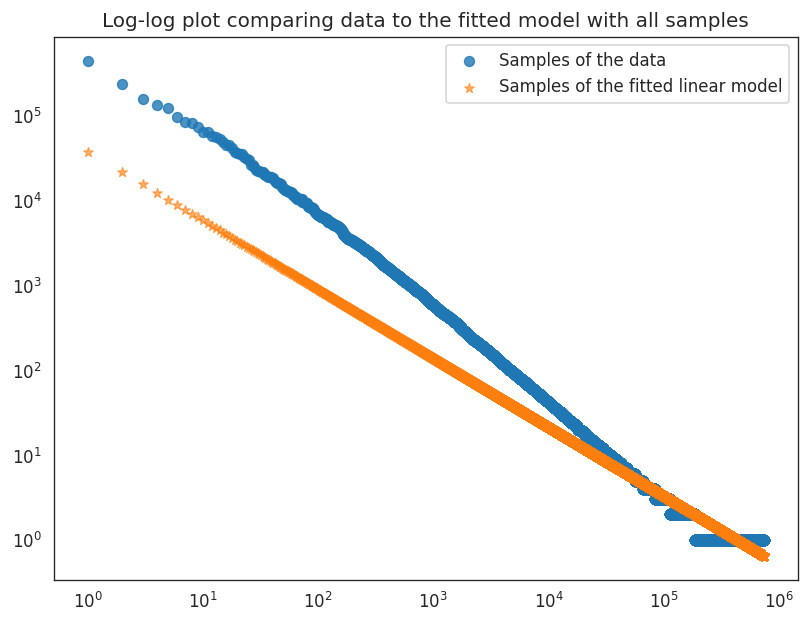

In [17]:
plot_log_model(
    df_exp,
    model_all,
    plot_title="Log-log plot comparing data to the fitted model with all samples",
)

In [27]:
# let's now truncate the nd of the distribution such as to avoid many ties:
tie_idx = np.where(df_exp["y"].values == 1)[0][0]

# now let's filter the dataframe up to that point where the ties begin with some leverage (500 points)
df_exp_filter = df_exp.head(tie_idx + 500).copy()

In [28]:
# fitting a model on the truncated dataset:
model_truncated = LinearRegression()

model_truncated.fit(
    df_exp_filter.x_log.values.reshape(-1, 1), df_exp_filter.y_log.values.reshape(-1, 1)
)

LinearRegression()

True

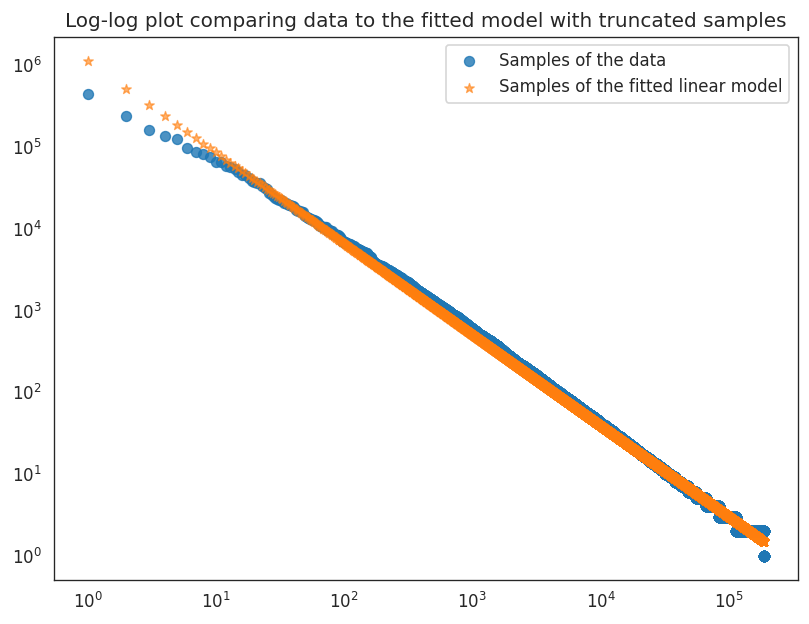

In [29]:
plot_log_model(
    df_exp_filter,
    model_truncated,
    plot_title="Log-log plot comparing data to the fitted model with truncated samples",
)

From the comparison in the plots above, we can see that the fit of the line with the truncated distribution is much better than to that of the full dataset. This allows us to lessen the effects of heavy tails that are common in this kind of data.

In [31]:
# extracting the parameters of the truncated model:
intercept_truncated = model_truncated.intercept_
slope_truncated = model_truncated.coef_

print(
    f"""
Linear model fitted on all samples:
    Intercept = {intercept_truncated[0]}
    Slope = {slope_truncated[0][0]}
"""
)


Linear model fitted on all samples:
    Intercept = 13.914399824318926
    Slope = -1.1124902795381317



In [32]:
# extracting the alpha parameter from both versions:
alpha_truncated = (slope_truncated - 1) / slope_truncated
alpha_full = (slope_all - 1) / slope_all

print(
    f"""
Alpha (scale) parameters estimated:
    
    Truncated = {alpha_truncated[0][0]}
    Full = {alpha_full[0][0]}
    
"""
)


Alpha (scale) parameters estimated:
    
    Truncated = 1.89888425849003
    Full = 2.231261231284259
    



In [66]:
# defining a sample of the zipf distribution using the selected parametr
np.random.seed(42)
zipf_sample_all = np.sort(np.random.zipf(a=alpha_full[0][0], size=len(df_exp)))[::-1]
zipf_sample_truncated = np.sort(
    2.56 * np.random.zipf(a=alpha_truncated[0][0], size=len(df_exp_filter))
)[::-1] # 2.56 is merely a location factor to the distribution (which numpy does not support by default)

Given that we estimated the distribution parameters, we can then perform a statistical test for goodness to assess whether the original samples and the ones simulated from the fitted Zipf distribution are similar enough to be considered from the same distribution. For that, we will perform a KS (Kolmogorov-Smirnov) test.

True

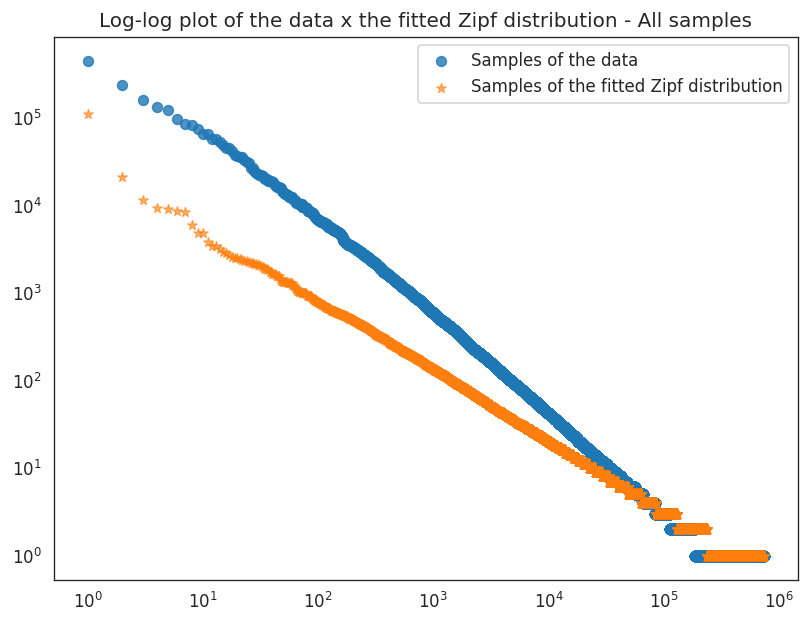

In [46]:
# plotting the original sample to the zipf distribution sample:
plot_zipf_sample(
    df_exp.x.values,
    df_exp.y.values,
    zipf_sample_all,
    "Log-log plot of the data x the fitted Zipf distribution - All samples",
)

True

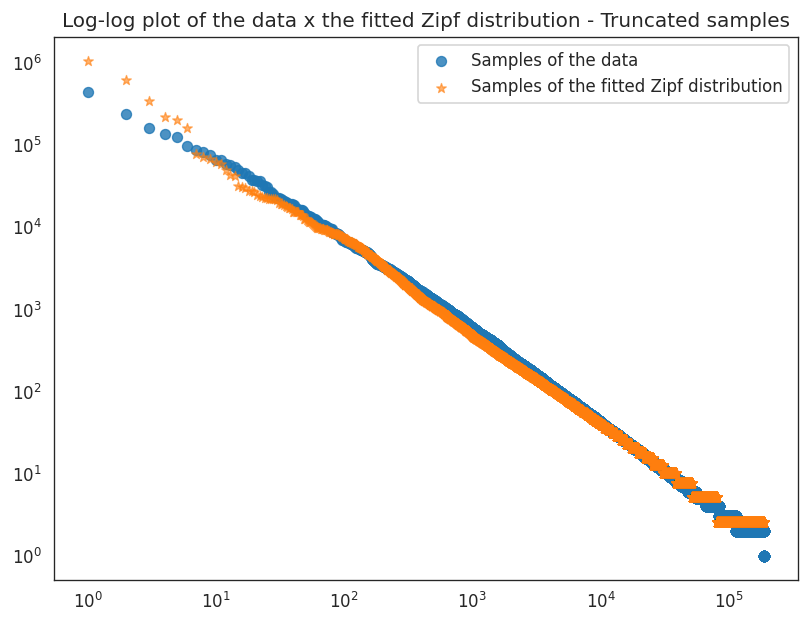

In [67]:
plot_zipf_sample(
    df_exp_filter.x.values,
    df_exp_filter.y.values,
    zipf_sample_truncated,
    "Log-log plot of the data x the fitted Zipf distribution - Truncated samples",
)

Apart from the scale, we can see that the distributions are quite close, especially towards the middle portion of the plot. The largest deviation is the first point in the rank, which is a full order of magnitude off. However, let's check if we sample the two datasets, what the KS test results would be.

In [82]:
# verifying the results of the KS test on a N = 20K sample
stats.ks_2samp(df_exp_filter.y.values[2000:22_000], zipf_sample_truncated[2000:22_000])

Ks_2sampResult(statistic=0.06525, pvalue=2.0907976028636333e-37)

The very small p-value suggests that we can reject the null hypothesis that both samples come from the same distribution. The D-statistic, however, is quite small (about `0.06`) and not that far from the one the researchers obtained (`0.014`). With this in mind, we can still work with the assumption that the data is sufficienly similar to the one derived from a Zipf distribution for our purposes and downstream modelling tasks.